# **ANÁLISIS EXPLORATORIO DE DATOS**

## 1. Dataset

➡️**Nombre:** Lending Club Loan Data (2007–2020) \
➡️**Fuente:** Kaggle Dataset - Lending Club \
➡️**Tamaño:** 2'260.701 registros en 151 variables de estudio 

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Cargar el dataset
file = r"C:\Users\Hp\MACHINE\MINI_PRY_1\data\data_lend.csv"
df = pd.read_csv(file, low_memory=False)

KeyboardInterrupt: 

In [ ]:
tipo_variables = df.dtypes.value_counts()
print("Cantidad de variables por tipo de dato:")
tabla_tipos = pd.DataFrame(tipo_variables).reset_index()
tabla_tipos.columns = ['Tipo de dato', 'Cantidad de variables']
tabla_tipos

Cantidad de variables por tipo de dato:


,Tipo de dato,Cantidad de variables
0,float64,90
1,object,10
2,int64,8


## 2. Variable objetivo

☑️ Variable binaria: ``default``

*   0 = Fully Paid
*   1 = Charged Off (default)

In [26]:
# Variable objetivo
# Generar la variable default basada en la columna loan_status:

df = df[df['loan_status'].isin(['Charged Off', 'Fully Paid'])].copy()
df['default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
df.drop(columns=['loan_status'], inplace=True)
df.shape

KeyError: 'loan_status'

➡️  Se trabajarán $1'345.310$ de registros que, luego de un proceso de preprocesamiento, se han resumido en 108 variables.  

In [25]:
df['default'].value_counts(normalize=True)

default
0    0.800374
1    0.199626
Name: proportion, dtype: float64

In [5]:
# Distribución de la variable objetivo
df['default'].value_counts(normalize=True)

table = pd.DataFrame(df['default'].value_counts())
table.index = ['Fully Paid', 'Charged Off']
table.columns = ['Count']
table['Percentage'] = round(table['Count'] / table['Count'].sum() * 100,2)
table['Percentage'] = table['Percentage'].astype(str) + '%'
table 

,Count,Percentage
Fully Paid,1076751,80.04%
Charged Off,268559,19.96%


In [6]:
conteo = df['default'].value_counts().reset_index()
conteo.columns = ['Cat', 'Frecuencia']
conteo['Cat'] = conteo['Cat'].replace({0: "Fully Paid", 1: "Default"})
colores = {"Fully Paid": "#4caf50", "Default": "#f44336"}

fig = px.pie(
    conteo,
    names='Cat',
    values='Frecuencia',
    hole=0.2,  # Donut chart
    color='Cat',  # Usamos la columna para mapear colores
    color_discrete_map=colores,
)
fig.update_traces(
    textinfo='percent+label',
    pull=[0.05]*len(conteo)
)
fig.update_layout(
    legend_title_text='Categoría',
    title={
        'text': 'Distribución de la variable default',
        'x': 0.5,  # Centrar el título
    },
    title_font=dict(size=20, color='black', family='Sans-serif'),
)
fig.show()

In [7]:
from statsmodels.stats.proportion import proportions_ztest

count = df['default'].sum()        # número de impagos
nobs = df.shape[0]                 # total de observaciones
value = 0.5                        # proporción hipotética

stat, pval = proportions_ztest(count, nobs, value)
print("z =", stat, "p-value =", pval)

z = -871.6020425210154 p-value = 0.0


In [8]:
real_prop = count / nobs
print(f"Proporción observada: {real_prop:.3f}")

Proporción observada: 0.200


La proporción de impagos observada en los registros es del 20%, mientras que la proporción hipotética planteada fue del 50%.
La diferencia entre ambas proporciones es estadísticamente significativa, como lo indica el p-valor ≈ 0, lo que permite rechazar la hipótesis nula.
El estadístico z negativo confirma que la proporción observada está significativamente por debajo de la proporción hipotética


## 3. Distribución de las variables de estudio

In [ ]:
corr = df.corr(numeric_only=True, method='spearman')["default"].sort_values(ascending=False)
corr[corr.abs() > 0.35]

default                    1.000000
recoveries                 0.795849
collection_recovery_fee    0.775646
total_pymnt_inv           -0.357998
total_pymnt               -0.358590
last_pymnt_amnt           -0.443629
total_rec_prncp           -0.519936
last_fico_range_high      -0.608131
last_fico_range_low       -0.608145
Name: default, dtype: float64

In [15]:
from scipy.stats import chi2_contingency

for col in df.select_dtypes(include='object'):
    tabla = pd.crosstab(df[col], df['default'])
    chi2, p, _, _ = chi2_contingency(tabla)
    print(f"{col}: p-valor = {p:.4f}")

grade: p-valor = 0.0000
sub_grade: p-valor = 0.0000
home_ownership: p-valor = 0.0000
verification_status: p-valor = 0.0000
loan_status: p-valor = 0.0000
purpose: p-valor = 0.0000
addr_state: p-valor = 0.0000
initial_list_status: p-valor = 0.0000
application_type: p-valor = 0.0000
disbursement_method: p-valor = 0.8307


In [23]:
import numpy as np

def cramers_v(x, y):
    tabla = pd.crosstab(x, y)
    chi2 = chi2_contingency(tabla)[0]
    n = tabla.sum().sum()
    phi2 = chi2 / n
    r, k = tabla.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for col in df.select_dtypes(include='object'):
    v = cramers_v(df[col], df['default'])
    print(f"{col}: Cramér's V = {v:.3f}")

grade: Cramér's V = 0.262
sub_grade: Cramér's V = 0.268
home_ownership: Cramér's V = 0.071
verification_status: Cramér's V = 0.092
loan_status: Cramér's V = 1.000
purpose: Cramér's V = 0.055
addr_state: Cramér's V = 0.050
initial_list_status: Cramér's V = 0.007
application_type: Cramér's V = 0.016
disbursement_method: Cramér's V = 0.000


🔹 CANTIDADES Y MONTOS
* Monto del crédito
* Valor solicitado
* Cuota mensual
* Plazo del crédito
* Tasa de interés

Descripción del dinero en crédito

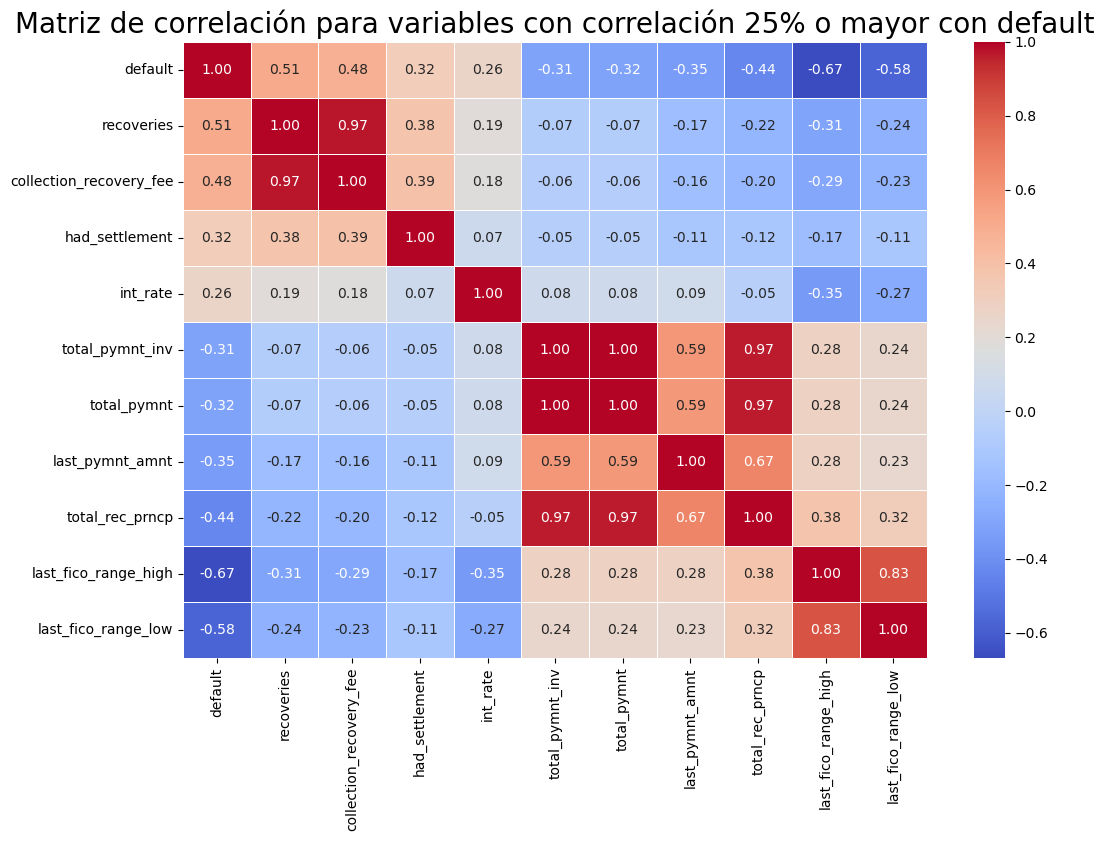

In [22]:
# Matriz de correlación para variables numéricas mayor a 0.35
corr_25 = corr[corr.abs() > 0.25]
plt.figure(figsize=(12, 8))
sns.heatmap(df[corr_25.index].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación para variables con correlación 25% o mayor con default', fontsize=20)   
plt.show()



In [19]:
corr = df.corr(numeric_only=True, method='spearman')["default"].sort_values(ascending=False)
corr[corr.abs() > 0.20]

default                    1.000000
recoveries                 0.795849
collection_recovery_fee    0.775646
had_settlement             0.318823
int_rate                   0.254094
total_rec_late_fee         0.214662
total_pymnt_inv           -0.357998
total_pymnt               -0.358590
last_pymnt_amnt           -0.443629
total_rec_prncp           -0.519936
last_fico_range_high      -0.608131
last_fico_range_low       -0.608145
Name: default, dtype: float64